In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import optuna
import math
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import  train_test_split
from lazypredict.Supervised import  LazyClassifier
import seaborn as sns
import scipy.stats
import lightgbm as lgbm
from sklearn.metrics import log_loss

In [189]:
data_train=pd.read_csv('datasets/Spaceship/train.csv')
data_test=pd.read_csv('datasets/Spaceship/test.csv')

In [190]:
test_Id=data_test["PassengerId"]
test_Id

0       0013_01
1       0018_01
2       0019_01
3       0021_01
4       0023_01
         ...   
4272    9266_02
4273    9269_01
4274    9271_01
4275    9273_01
4276    9277_01
Name: PassengerId, Length: 4277, dtype: object

In [191]:
def feature_split(df):
    df["PassengerId_Group"]=df["PassengerId"].str.split("_",expand=True)[0].astype(np.int)
    df["PassengerId_GroupNumber"]=df["PassengerId"].str.split("_",expand=True)[1].astype(np.int)
    df["Cabin_Deck"]=df["Cabin"].str.split("/",expand=True)[0].astype("string")
    df["Cabin_Num"]=df["Cabin"].str.split("/",expand=True)[1].astype("string")
    df["Cabin_Side"]=df["Cabin"].str.split("/",expand=True)[2].astype("string")
    return df

In [192]:
data=feature_split(data_train)

In [193]:
data

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0001_01     Europa     False     B/0/P    TRAPPIST-1e 39.00  False   
1        0002_01      Earth     False     F/0/S    TRAPPIST-1e 24.00  False   
2        0003_01     Europa     False     A/0/S    TRAPPIST-1e 58.00   True   
3        0003_02     Europa     False     A/0/S    TRAPPIST-1e 33.00  False   
4        0004_01      Earth     False     F/1/S    TRAPPIST-1e 16.00  False   
...          ...        ...       ...       ...            ...   ...    ...   
8688     9276_01     Europa     False    A/98/P    55 Cancri e 41.00   True   
8689     9278_01      Earth      True  G/1499/S  PSO J318.5-22 18.00  False   
8690     9279_01      Earth     False  G/1500/S    TRAPPIST-1e 26.00  False   
8691     9280_01     Europa     False   E/608/S    55 Cancri e 32.00  False   
8692     9280_02     Europa     False   E/608/S    TRAPPIST-1e 44.00  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0            0.00       0.00          0.00    0.00    0.00    Maham Ofracculy   
1          109.00       9.00         25.00  549.00   44.00       Juanna Vines   
2           43.00    3576.00          0.00 6715.00   49.00      Altark Susent   
3            0.00    1283.00        371.00 3329.00  193.00       Solam Susent   
4          303.00      70.00        151.00  565.00    2.00  Willy Santantines   
...           ...        ...           ...     ...     ...                ...   
8688         0.00    6819.00          0.00 1643.00   74.00  Gravior Noxnuther   
8689         0.00       0.00          0.00    0.00    0.00    Kurta Mondalley   
8690         0.00       0.00       1872.00    1.00    0.00       Fayey Connon   
8691         0.00    1049.00          0.00  353.00 3235.00   Celeon Hontichre   
8692       126.00    4688.00          0.00    0.00   12.00   Propsh Hontichre   

      Transported  PassengerId_Group  PassengerId_GroupNumber Cabin_Deck  \
0           False                  1                        1          B   
1            True                  2                        1          F   
2           False                  3                        1          A   
3           False                  3                        2          A   
4            True                  4                        1          F   
...           ...                ...                      ...        ...   
8688        False               9276                        1          A   
8689        False               9278                        1          G   
8690         True               9279                        1          G   
8691        False               9280                        1          E   
8692         True               9280                        2          E   

     Cabin_Num Cabin_Side  
0            0          P  
1            0          S  
2            0          S  
3            0          S  
4            1          S  
...        ...        ...  
8688        98          P  
8689      1499          S  
8690      1500          S  
8691       608          S  
8692       608          S  

[8693 rows x 19 columns]

In [194]:
data_train.isna().sum()

PassengerId                  0
HomePlanet                 201
CryoSleep                  217
Cabin                      199
Destination                182
Age                        179
VIP                        203
RoomService                181
FoodCourt                  183
ShoppingMall               208
Spa                        183
VRDeck                     188
Name                       200
Transported                  0
PassengerId_Group            0
PassengerId_GroupNumber      0
Cabin_Deck                 199
Cabin_Num                  199
Cabin_Side                 199
dtype: int64

In [195]:
def check_nulls(df): # Function that will be used to plot nulls values
    fig = px.imshow(df.isna().astype(np.int8), color_continuous_scale = ['#304fa7','#8bb7cf'],
                    title = 'HeatMap for Null Values', height = 400)
    fig.show()
    fig = px.bar(x = df.isna().mean().sort_values().index, y = df.isna().mean().sort_values().values,
                 color_discrete_sequence=['#304fa7'], title = 'Null Value ratio feature wise',
                 labels = {'x':'Feature','y':'Ratio'}, height = 400)
    #fig.update_layout(height=400)
    fig.show()

In [196]:
check_nulls(data_train)

In [197]:
data.select_dtypes(exclude="number").nunique()

PassengerId    8693
HomePlanet        3
CryoSleep         2
Cabin          6560
Destination       3
VIP               2
Name           8473
Transported       2
Cabin_Deck        8
Cabin_Num      1817
Cabin_Side        2
dtype: int64

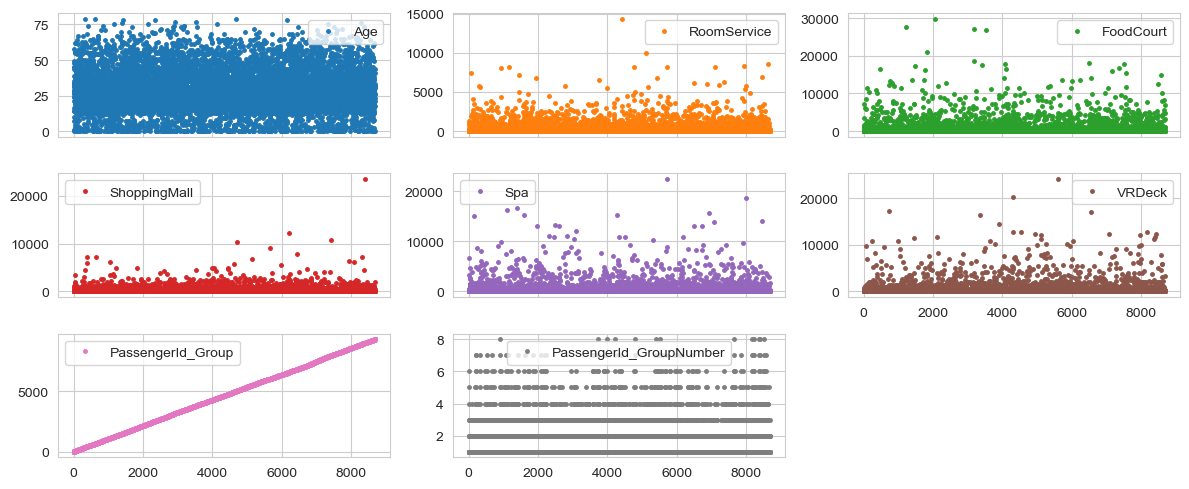

In [198]:
data_train.plot(lw=0,marker=".",subplots=True,layout=(-1,3),figsize=(12,5),markersize=5)
plt.tight_layout()

In [199]:
data.nunique()

PassengerId                8693
HomePlanet                    3
CryoSleep                     2
Cabin                      6560
Destination                   3
Age                          80
VIP                           2
RoomService                1273
FoodCourt                  1507
ShoppingMall               1115
Spa                        1327
VRDeck                     1306
Name                       8473
Transported                   2
PassengerId_Group          6217
PassengerId_GroupNumber       8
Cabin_Deck                    8
Cabin_Num                  1817
Cabin_Side                    2
dtype: int64

In [200]:
categorical_features=data.select_dtypes("object").columns

In [201]:
def view_categorical(df, categorical_threshold): # Function that plots categorical values
    categorical_features = df.select_dtypes(exclude = "number").nunique()[df.select_dtypes(
        exclude = "number").nunique() <= categorical_threshold].index.tolist()

    figsize = (13,5)
    cols = 4
    rows = math.ceil(len(categorical_features) / cols)

    plt.subplots(rows,cols,figsize = figsize)
    for i in range(len(categorical_features)):
        plt.subplot(rows,cols,i + 1)
        df[categorical_features[i]].value_counts().sort_values().plot.bar(color = '#304fa7')
        plt.xticks(rotation = 45)
        plt.title(categorical_features[i])

    plt.tight_layout()
    plt.show()

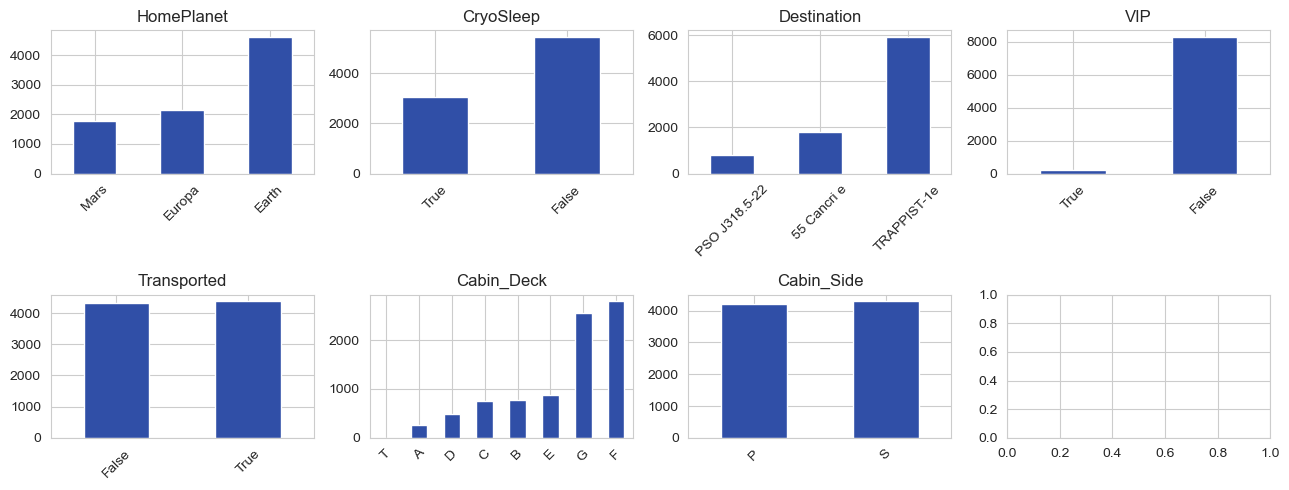

In [202]:
view_categorical(data,16)

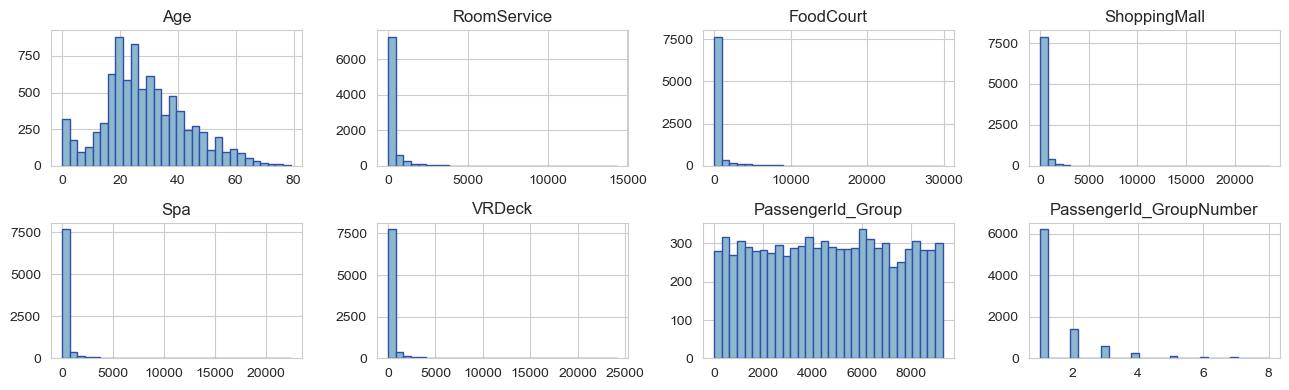

In [203]:
figsize_val = (13,4)
layout_val = (-1, 4)
data_train.hist(bins = 30, figsize = figsize_val, layout = layout_val,
                edgecolor = '#304fa7', color = '#8bb7cf')
plt.tight_layout()

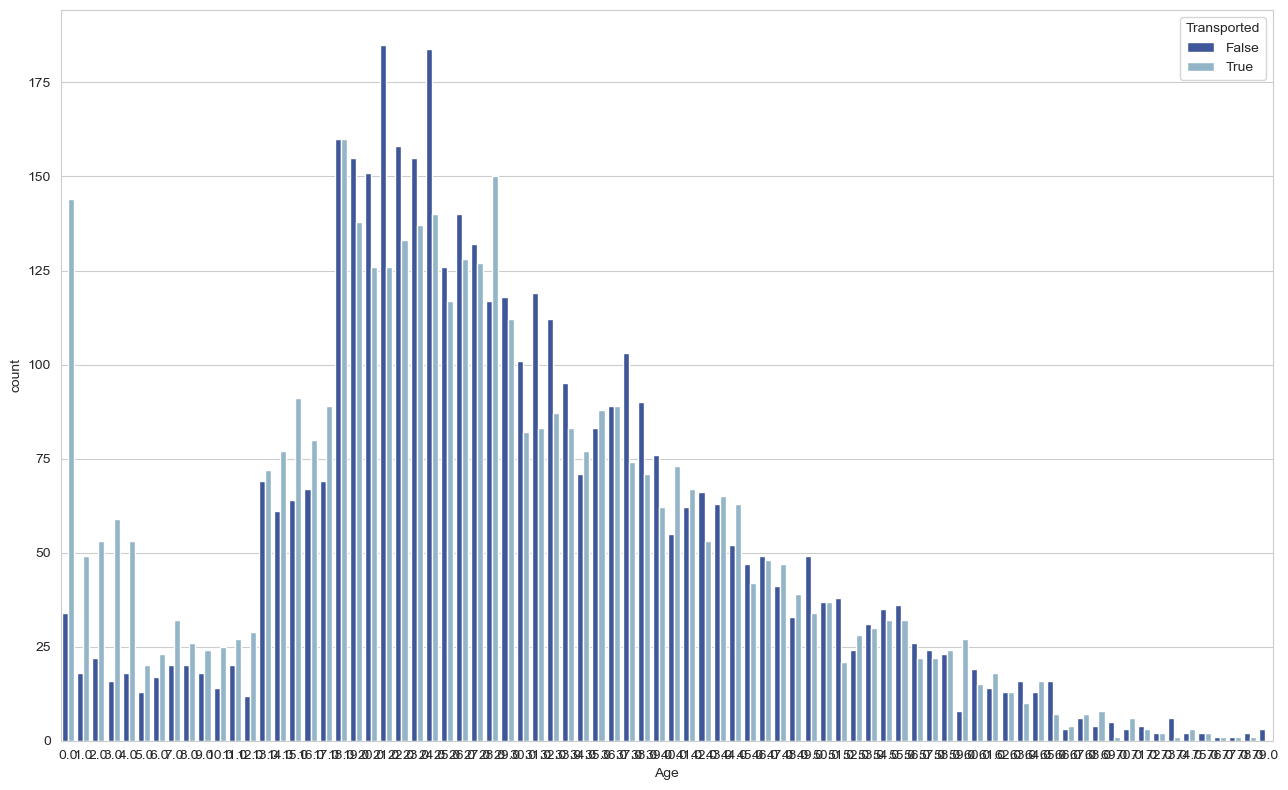

In [204]:
plt.figure(figsize=(13,8))
sns.countplot(data=data_train, x='Age', hue="Transported", palette = ['#304fa7','#8bb7cf'])
plt.tight_layout()

In [205]:
def check_outliers(df):
    df = df[(df.select_dtypes(include = 'number').columns).to_list()]

    upper_threshold = df.quantile(0.75) + 1.5 * (df.quantile(0.75) - df.quantile(0.25))
    lower_threshold = df.quantile(0.25) - 1.5 * (df.quantile(0.75) - df.quantile(0.25))

    for i in df.select_dtypes(include = 'number'):
        print('\nColumn -> ',i,'')
        x = df[(df[i] < round(lower_threshold[i],2)) | (df[i] > round(upper_threshold[i],2))][i].to_list()
        print('No of Outliers presesnt -> ',len(x))
        print('\n','*' * 10)

In [206]:
check_outliers(data)


Column ->  Age 
No of Outliers presesnt ->  77

 **********

Column ->  RoomService 
No of Outliers presesnt ->  1861

 **********

Column ->  FoodCourt 
No of Outliers presesnt ->  1823

 **********

Column ->  ShoppingMall 
No of Outliers presesnt ->  1829

 **********

Column ->  Spa 
No of Outliers presesnt ->  1788

 **********

Column ->  VRDeck 
No of Outliers presesnt ->  1809

 **********

Column ->  PassengerId_Group 
No of Outliers presesnt ->  0

 **********

Column ->  PassengerId_GroupNumber 
No of Outliers presesnt ->  493

 **********


In [207]:
data1=data.copy()

In [208]:
outliers_to_drop=[77,1861,1823,1829,1809,0,493]

In [209]:
print("Before: {} rows".format(len(data1)))
data1= data1.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
print("After: {} rows".format(len(data1)))

Before: 8693 rows
After: 8686 rows


In [210]:
data2=data1.copy()

In [211]:
target = data_train[['Transported']].value_counts(normalize = True).round(decimals = 3) * 100

pal, color = ['#304fa7','#8bb7cf'], ['#304fa7','#8bb7cf']
fig = go.Figure()

fig.add_trace(go.Pie(labels = target.index, values = target, hole = .5,
                     showlegend = True, sort = False,
                     marker = dict(colors = color,line = dict(color = pal,width = 1)),
                     hovertemplate = "%{label} Transported: %{value:.2f}%<extra></extra>"))

#fig.show()
plotly.offline.iplot(fig)

In [212]:
data2['Transported'].value_counts().sort_values(ascending=False)

True     4374
False    4312
Name: Transported, dtype: int64

In [213]:
def feature_stats(df, feature, target): # Function that obtain the stats of each category in a feature
    values_percentaje = (df[[feature,target]].value_counts(normalize = True)
                         .round(decimals = 3) * 100).reset_index().rename(columns = {0:'Overall_Percent'})

    values_perGroup = pd.merge(df.groupby([feature,target]).size().reset_index(name = 'category_size'),
                               df.groupby([feature]).size().reset_index(name = 'Total'), on = [feature])
    values_perGroup['Category_Percent'] = round((values_perGroup['category_size'] /
                                                 values_perGroup['Total']) * 100 ,2)

    values_merged = values_percentaje.merge(values_perGroup,on = [feature,target])
    return values_merged.pivot(columns = feature,
                               index = target)[['category_size', 'Category_Percent', 'Overall_Percent']]

In [214]:
data2.select_dtypes("object").columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name'],
      dtype='object')

In [215]:
data2.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'PassengerId_Group', 'PassengerId_GroupNumber',
       'Cabin_Deck', 'Cabin_Num', 'Cabin_Side'],
      dtype='object')

In [216]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8686 entries, 0 to 8685
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PassengerId              8686 non-null   object 
 1   HomePlanet               8485 non-null   object 
 2   CryoSleep                8469 non-null   object 
 3   Cabin                    8487 non-null   object 
 4   Destination              8504 non-null   object 
 5   Age                      8508 non-null   float64
 6   VIP                      8483 non-null   object 
 7   RoomService              8505 non-null   float64
 8   FoodCourt                8503 non-null   float64
 9   ShoppingMall             8478 non-null   float64
 10  Spa                      8503 non-null   float64
 11  VRDeck                   8498 non-null   float64
 12  Name                     8487 non-null   object 
 13  Transported              8686 non-null   bool   
 14  PassengerId_Group       

<AxesSubplot:xlabel='HomePlanet', ylabel='Transported'>

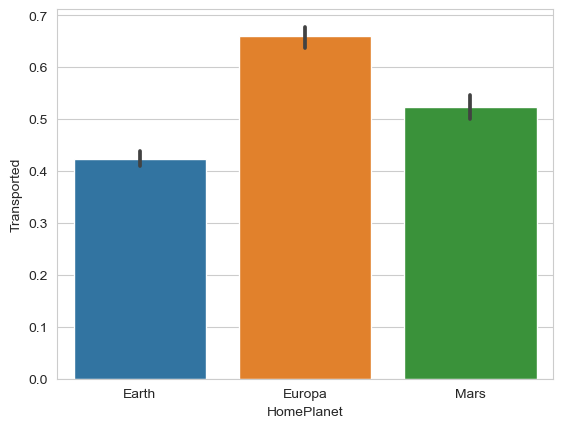

In [217]:
sns.barplot(x="HomePlanet",y="Transported",data=data2)

<AxesSubplot:xlabel='CryoSleep', ylabel='Transported'>

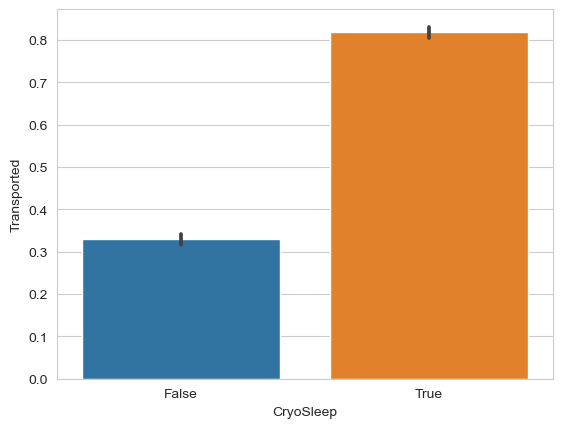

In [218]:
sns.barplot(x="CryoSleep",y="Transported",data=data2)

<AxesSubplot:xlabel='Destination', ylabel='Transported'>

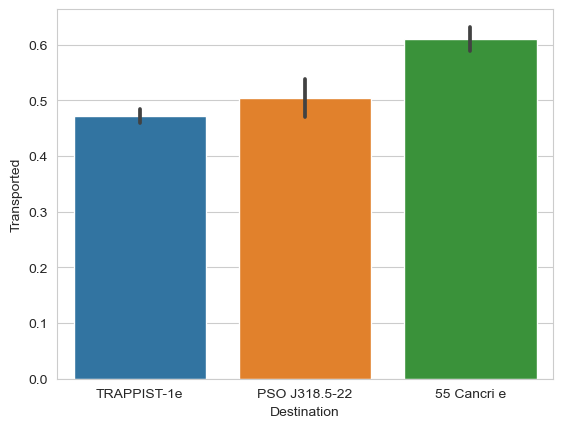

In [219]:
sns.barplot(x="Destination",y="Transported",data=data2)

<AxesSubplot:xlabel='VIP', ylabel='Transported'>

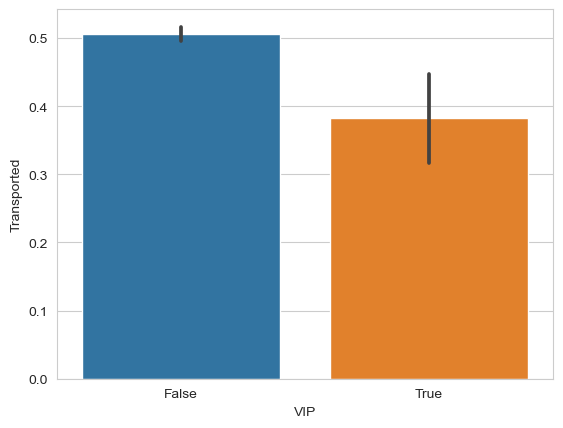

In [220]:
sns.barplot(x="VIP",y="Transported",data=data2)

<AxesSubplot:xlabel='PassengerId_GroupNumber', ylabel='Transported'>

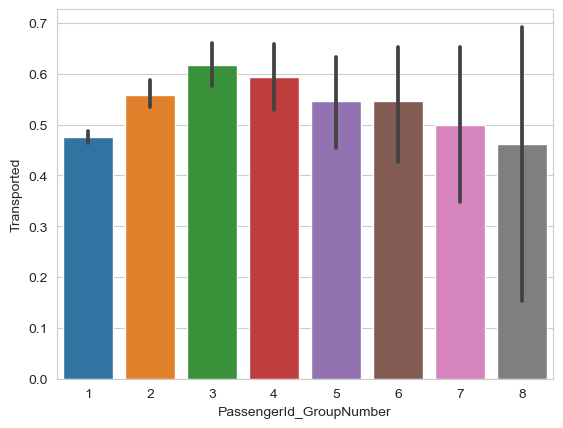

In [221]:
sns.barplot(x="PassengerId_GroupNumber",y="Transported",data=data2)

In [222]:
def numerical_target_relation(df, target):
    num_features = df.select_dtypes(include = 'number').columns.to_list()
    num_features.append(target)

    y = 4
    x = math.ceil((len(num_features) - 1) / y)
    plt.subplots(x,y,figsize = (13,7))
    for i in range(1,len(num_features)-1) :
        plt.subplot(x,y,i)
        sns.pointplot(data = df[num_features], y = num_features[i - 1], x = target, color = '#00369c')

    plt.tight_layout()
    plt.show()

In [223]:
def delete_irrelenvant_features(df): # Deleting irrelevant features
    df = df.drop(columns = ['PassengerId', 'PassengerId_GroupNumber', 'Name', 'Cabin_Num', 'Cabin'],
                 axis = 1, errors = 'ignore')
    return df

In [224]:
def imputeNull(df): # Imputes null values
    # Imputing Nulls from categorical columns
    df['HomePlanet'].fillna(df['HomePlanet'].mode(), inplace = True)
    df['CryoSleep'].fillna(df['CryoSleep'].mode(), inplace = True)
    df['Destination'].fillna(df['Destination'].mode(), inplace = True)
    df['VIP'].fillna(df['VIP'].mode(), inplace=True)
    df['Cabin_Deck'].fillna(df['Cabin_Deck'].mode(), inplace = True)
    df['Cabin_Side'].fillna(df['Cabin_Side'].mode(), inplace = True)

    # Imputing Nulls from numerical columns
    df[df['CryoSleep'] == True][['RoomService', 'FoodCourt', 'ShoppingMall',
                                 'Spa', 'VRDeck']].fillna(0, inplace = True)
    # If you are sleep, you can't buy anything
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['RoomService'].fillna(df['RoomService'].median(), inplace = True)
    df['FoodCourt'].fillna(df['FoodCourt'].median(), inplace = True)
    df['ShoppingMall'].fillna(df['ShoppingMall'].median(), inplace = True)
    df['Spa'].fillna(df['Spa'].median(), inplace = True)
    df['VRDeck'].fillna(df['VRDeck'].median(), inplace = True)
    #df['Cabin_Num'].fillna(df['Cabin_Num'].median(), inplace=True)

    return df

In [225]:
def onehot_encoder(df, feature): # Makes one hot encoder with pandas get_dummies function
    dummies = pd.get_dummies(df[feature], prefix = feature)
    df = pd.concat([df,dummies], axis = 1)
    df = df.drop(columns = [feature], axis = 1)
    return df

In [226]:
def onehot_encoder_boolean(df, feature): # Makes one hot encoder in a single column
    dummies = pd.get_dummies(df[feature], prefix = feature, drop_first = True)
    df = pd.concat([df,dummies], axis = 1)
    df = df.drop(columns = [feature], axis = 1)
    return df

In [227]:
def label_encoder_onehot(df): # Makes one hot encoder for every categorical feature

    df = onehot_encoder(df, 'HomePlanet')
    df = onehot_encoder_boolean(df, 'CryoSleep')
    df = onehot_encoder(df, 'Destination')
    df = onehot_encoder_boolean(df, 'VIP')
    df = onehot_encoder(df, 'Cabin_Deck')
    df = onehot_encoder(df, 'Cabin_Side')

    return df

In [228]:
def feature_augmentation(df): # Function that creates new features which can be useful
    df['HasPaid'] = (df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']) > 0
    df['Paid'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    df['HasPaid_RoomService'] = (df['RoomService']) > 0
    df['HasPaid_FoodCourt'] = (df['FoodCourt']) > 0
    df['HasPaid_ShoppingMall'] = (df['ShoppingMall']) > 0
    df['HasPaid_Spa'] = (df['Spa']) > 0
    df['HasPaid_VRDeck'] = (df['VRDeck']) > 0
    df['IsAdult'] = (df['VRDeck']) > 17
    df["IsEmbryo"] = np.isclose(df["Age"], 0.0)

    df['HasPaid'] = df['HasPaid'].astype(int)
    df['HasPaid_RoomService'] = df['HasPaid_RoomService'].astype(int)
    df['HasPaid_FoodCourt'] = df['HasPaid_FoodCourt'].astype(int)
    df['HasPaid_ShoppingMall'] = df['HasPaid_ShoppingMall'].astype(int)
    df['HasPaid_Spa'] = df['HasPaid_Spa'].astype(int)
    df['HasPaid_VRDeck'] = df['HasPaid_VRDeck'].astype(int)
    df['IsAdult'] = df['IsAdult'].astype(int)
    df['IsEmbryo'] = df['IsEmbryo'].astype(int)
    return df

In [229]:
def replaceSpaces(df):
    df.columns = df.columns.str.replace(' ', '_')
    return df

In [230]:
def preProcess(df, imputingNulls = True):
    df = feature_split(df) # Splits cabin and PassengerId features

    df = delete_irrelenvant_features(df) # Removes irrelevant columns

    if imputingNulls == True:
        df = imputeNull(df) # Impute null values

    #df = label_encoder(df) # Encode categorical features
    df = label_encoder_onehot(df)

    df = feature_augmentation(df)

    df = replaceSpaces(df)

    return df

In [231]:
def preProcess_analytics(df, imputingNulls = True):
    df = feature_split(df) # Splits cabin and PassengerId features

    #df = delete_irrelenvant_features(df) # Removes irrelevant columns

    if imputingNulls == True:
        df = imputeNull(df) # Impute null values

    #df = label_encoder(df) # Encode categorical features
    df = label_encoder_onehot(df)

    df = feature_augmentation(df)

    df = replaceSpaces(df)

    return df

In [232]:
y = data2['Transported']
X = data2.drop(columns = 'Transported', axis = 1)
X_train , X_test , y_train , y_test = train_test_split(X, y, stratify = y,
                                                       random_state = 5, test_size = 0.40)
X_train = preProcess(X_train, imputingNulls = True)
X_test = preProcess(X_test, imputingNulls = True)
X_preProcessed = preProcess(X, imputingNulls = True)

data_test_preProcessed = preProcess(data_test, imputingNulls = True)

In [233]:
clf = LazyClassifier(verbose = 0,
                     ignore_warnings = True,
                     custom_metric = None,
                     predictions = False,
                     random_state = 12,
                     classifiers = 'all')

models, predictions = clf.fit(X_train, X_test ,y_train , y_test)

100%|██████████| 29/29 [00:38<00:00,  1.33s/it]


In [234]:
models

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.81               0.81     0.81      0.81   
XGBClassifier                      0.80               0.80     0.80      0.80   
RandomForestClassifier             0.80               0.80     0.80      0.80   
SVC                                0.79               0.79     0.79      0.79   
LogisticRegression                 0.79               0.79     0.79      0.79   
LinearSVC                          0.79               0.79     0.79      0.79   
AdaBoostClassifier                 0.79               0.79     0.79      0.79   
SGDClassifier                      0.79               0.79     0.79      0.79   
CalibratedClassifierCV             0.79               0.79     0.79      0.79   
ExtraTreesClassifier               0.79               0.79     0.79      0.78   
NuSVC                              0.78               0.78     0.78      0.78   
LinearDiscriminantAnalysis         0.78               0.78     0.78      0.78   
RidgeClassifier                    0.78               0.78     0.78      0.78   
RidgeClassifierCV                  0.78               0.78     0.78      0.78   
GaussianNB                         0.77               0.77     0.77      0.77   
QuadraticDiscriminantAnalysis      0.77               0.77     0.77      0.77   
BaggingClassifier                  0.77               0.77     0.77      0.77   
KNeighborsClassifier               0.76               0.76     0.76      0.76   
DecisionTreeClassifier             0.74               0.74     0.74      0.74   
LabelPropagation                   0.74               0.74     0.74      0.74   
LabelSpreading                     0.74               0.74     0.74      0.74   
NearestCentroid                    0.73               0.74     0.74      0.73   
BernoulliNB                        0.73               0.73     0.73      0.73   
PassiveAggressiveClassifier        0.73               0.73     0.73      0.73   
ExtraTreeClassifier                0.73               0.73     0.73      0.73   
Perceptron                         0.69               0.69     0.69      0.69   
DummyClassifier                    0.50               0.50     0.50      0.34   

                               Time Taken  
Model                                      
LGBMClassifier                       0.56  
XGBClassifier                        1.54  
RandomForestClassifier               1.56  
SVC                                  5.08  
LogisticRegression                   0.09  
LinearSVC                            1.13  
AdaBoostClassifier                   0.91  
SGDClassifier                        0.16  
CalibratedClassifierCV               4.73  
ExtraTreesClassifier                 1.15  
NuSVC                                6.77  
LinearDiscriminantAnalysis           0.08  
RidgeClassifier                      0.15  
RidgeClassifierCV                    0.29  
GaussianNB                           0.05  
QuadraticDiscriminantAnalysis        0.42  
BaggingClassifier                    0.49  
KNeighborsClassifier                 1.02  
DecisionTreeClassifier               0.11  
LabelPropagation                     5.58  
LabelSpreading                       6.12  
NearestCentroid                      0.03  
BernoulliNB                          0.12  
PassiveAggressiveClassifier          0.07  
ExtraTreeClassifier                  0.05  
Perceptron                           0.06  
DummyClassifier                      0.05

In [235]:
from sklearn.model_selection import StratifiedKFold
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [236]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X_preProcessed, y)
study.optimize(func, n_trials=20)

[I 2023-02-19 23:16:57,597] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] min_gain_to_split is set=5.967263375879704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.967263375879704
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's binary_logloss: 0.693151
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.693151
[3]	valid_0's binary_logloss: 

[I 2023-02-19 23:17:02,314] Trial 0 finished with value: 0.693121764936954 and parameters: {'n_estimators': 10000, 'learning_rate': 0.207358296626789, 'num_leaves': 1400, 'max_depth': 11, 'min_data_in_leaf': 6300, 'lambda_l1': 30, 'lambda_l2': 50, 'min_gain_to_split': 5.967263375879704, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.693121764936954.


[1]	valid_0's binary_logloss: 0.693162
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.693162
[3]	valid_0's binary_logloss: 0.693162
[4]	valid_0's binary_logloss: 0.693162
[5]	valid_0's binary_logloss: 0.693162
[6]	valid_0's binary_logloss: 0.693162
[7]	valid_0's binary_logloss: 0.693162
[8]	valid_0's binary_logloss: 0.693162
[9]	valid_0's binary_logloss: 0.693162
[10]	valid_0's binary_logloss: 0.693162
[11]	valid_0's binary_logloss: 0.693162
[12]	valid_0's binary_logloss: 0.693162
[13]	valid_0's binary_logloss: 0.693162
[14]	valid_0's binary_logloss: 0.693162
[15]	valid_0's binary_logloss: 0.693162
[16]	valid_0's binary_logloss: 0.693162
[17]	valid_0's binary_logloss: 0.693162
[18]	valid_0's binary_logloss: 0.693162
[19]	valid_0's binary_logloss: 0.693162
[20]	valid_0's binary_logloss: 0.693162
[21]	valid_0's binary_logloss: 0.693162
[22]	valid_0's binary_logloss: 0.693162
[23]	valid_0's binary_logloss: 0.693162
[24]	valid_0's binary_loglo

[I 2023-02-19 23:17:10,848] Trial 1 finished with value: 0.4945276239800925 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26689408742436765, 'num_leaves': 2780, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 50, 'lambda_l2': 55, 'min_gain_to_split': 8.186946119412044, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 1 with value: 0.4945276239800925.


[375]	valid_0's binary_logloss: 0.486269
[376]	valid_0's binary_logloss: 0.486269
[377]	valid_0's binary_logloss: 0.486269
[378]	valid_0's binary_logloss: 0.486269
[379]	valid_0's binary_logloss: 0.486269
[380]	valid_0's binary_logloss: 0.486269
[381]	valid_0's binary_logloss: 0.486269
[382]	valid_0's binary_logloss: 0.486269
[383]	valid_0's binary_logloss: 0.486269
[384]	valid_0's binary_logloss: 0.486269
[385]	valid_0's binary_logloss: 0.486269
[386]	valid_0's binary_logloss: 0.486269
Early stopping, best iteration is:
[286]	valid_0's binary_logloss: 0.486269
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=6.954480791424032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.954480791424032
[LightGBM] [Warning] lambda_l1

[I 2023-02-19 23:17:16,933] Trial 2 finished with value: 0.5809725206242409 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27272684671465286, 'num_leaves': 1920, 'max_depth': 6, 'min_data_in_leaf': 1400, 'lambda_l1': 100, 'lambda_l2': 0, 'min_gain_to_split': 6.954480791424032, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 1 with value: 0.4945276239800925.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=14.35773208222826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.35773208222826
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's binary_logloss: 0.693151
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.693151
[3]	valid_0's binary_logloss: 0.

[I 2023-02-19 23:17:19,277] Trial 3 finished with value: 0.693121764936954 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09601005526335138, 'num_leaves': 1080, 'max_depth': 4, 'min_data_in_leaf': 5100, 'lambda_l1': 35, 'lambda_l2': 0, 'min_gain_to_split': 14.35773208222826, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 1 with value: 0.4945276239800925.


[61]	valid_0's binary_logloss: 0.693162
[62]	valid_0's binary_logloss: 0.693162
[63]	valid_0's binary_logloss: 0.693162
[64]	valid_0's binary_logloss: 0.693162
[65]	valid_0's binary_logloss: 0.693162
[66]	valid_0's binary_logloss: 0.693162
[67]	valid_0's binary_logloss: 0.693162
[68]	valid_0's binary_logloss: 0.693162
[69]	valid_0's binary_logloss: 0.693162
[70]	valid_0's binary_logloss: 0.693162
[71]	valid_0's binary_logloss: 0.693162
[72]	valid_0's binary_logloss: 0.693162
[73]	valid_0's binary_logloss: 0.693162
[74]	valid_0's binary_logloss: 0.693162
[75]	valid_0's binary_logloss: 0.693162
[76]	valid_0's binary_logloss: 0.693162
[77]	valid_0's binary_logloss: 0.693162
[78]	valid_0's binary_logloss: 0.693162
[79]	valid_0's binary_logloss: 0.693162
[80]	valid_0's binary_logloss: 0.693162
[81]	valid_0's binary_logloss: 0.693162
[82]	valid_0's binary_logloss: 0.693162
[83]	valid_0's binary_logloss: 0.693162
[84]	valid_0's binary_logloss: 0.693162
[85]	valid_0's binary_logloss: 0.693162


[I 2023-02-19 23:17:21,491] Trial 4 finished with value: 0.693121764936954 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17096606225522762, 'num_leaves': 2500, 'max_depth': 6, 'min_data_in_leaf': 7600, 'lambda_l1': 25, 'lambda_l2': 65, 'min_gain_to_split': 10.580782037826525, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 1 with value: 0.4945276239800925.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=6.35685705585948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.35685705585948
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's binary_logloss: 0.693151
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.693151
[3]	valid_0's binary_logloss: 0.69

[I 2023-02-19 23:17:24,765] Trial 5 finished with value: 0.693121764936954 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07509875478726956, 'num_leaves': 1840, 'max_depth': 12, 'min_data_in_leaf': 3100, 'lambda_l1': 5, 'lambda_l2': 60, 'min_gain_to_split': 6.35685705585948, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 1 with value: 0.4945276239800925.


[53]	valid_0's binary_logloss: 0.693162
[54]	valid_0's binary_logloss: 0.693162
[55]	valid_0's binary_logloss: 0.693162
[56]	valid_0's binary_logloss: 0.693162
[57]	valid_0's binary_logloss: 0.693162
[58]	valid_0's binary_logloss: 0.693162
[59]	valid_0's binary_logloss: 0.693162
[60]	valid_0's binary_logloss: 0.693162
[61]	valid_0's binary_logloss: 0.693162
[62]	valid_0's binary_logloss: 0.693162
[63]	valid_0's binary_logloss: 0.693162
[64]	valid_0's binary_logloss: 0.693162
[65]	valid_0's binary_logloss: 0.693162
[66]	valid_0's binary_logloss: 0.693162
[67]	valid_0's binary_logloss: 0.693162
[68]	valid_0's binary_logloss: 0.693162
[69]	valid_0's binary_logloss: 0.693162
[70]	valid_0's binary_logloss: 0.693162
[71]	valid_0's binary_logloss: 0.693162
[72]	valid_0's binary_logloss: 0.693162
[73]	valid_0's binary_logloss: 0.693162
[74]	valid_0's binary_logloss: 0.693162
[75]	valid_0's binary_logloss: 0.693162
[76]	valid_0's binary_logloss: 0.693162
[77]	valid_0's binary_logloss: 0.693162


[I 2023-02-19 23:17:27,024] Trial 6 finished with value: 0.693121764936954 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04829188718590868, 'num_leaves': 1240, 'max_depth': 11, 'min_data_in_leaf': 4700, 'lambda_l1': 10, 'lambda_l2': 15, 'min_gain_to_split': 7.531114111124731, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 1 with value: 0.4945276239800925.


[74]	valid_0's binary_logloss: 0.693162
[75]	valid_0's binary_logloss: 0.693162
[76]	valid_0's binary_logloss: 0.693162
[77]	valid_0's binary_logloss: 0.693162
[78]	valid_0's binary_logloss: 0.693162
[79]	valid_0's binary_logloss: 0.693162
[80]	valid_0's binary_logloss: 0.693162
[81]	valid_0's binary_logloss: 0.693162
[82]	valid_0's binary_logloss: 0.693162
[83]	valid_0's binary_logloss: 0.693162
[84]	valid_0's binary_logloss: 0.693162
[85]	valid_0's binary_logloss: 0.693162
[86]	valid_0's binary_logloss: 0.693162
[87]	valid_0's binary_logloss: 0.693162
[88]	valid_0's binary_logloss: 0.693162
[89]	valid_0's binary_logloss: 0.693162
[90]	valid_0's binary_logloss: 0.693162
[91]	valid_0's binary_logloss: 0.693162
[92]	valid_0's binary_logloss: 0.693162
[93]	valid_0's binary_logloss: 0.693162
[94]	valid_0's binary_logloss: 0.693162
[95]	valid_0's binary_logloss: 0.693162
[96]	valid_0's binary_logloss: 0.693162
[97]	valid_0's binary_logloss: 0.693162
[98]	valid_0's binary_logloss: 0.693162


[I 2023-02-19 23:17:29,517] Trial 7 finished with value: 0.693121764936954 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19430926961203449, 'num_leaves': 1740, 'max_depth': 7, 'min_data_in_leaf': 7400, 'lambda_l1': 15, 'lambda_l2': 30, 'min_gain_to_split': 3.2870667670363805, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 1 with value: 0.4945276239800925.


[89]	valid_0's binary_logloss: 0.693162
[90]	valid_0's binary_logloss: 0.693162
[91]	valid_0's binary_logloss: 0.693162
[92]	valid_0's binary_logloss: 0.693162
[93]	valid_0's binary_logloss: 0.693162
[94]	valid_0's binary_logloss: 0.693162
[95]	valid_0's binary_logloss: 0.693162
[96]	valid_0's binary_logloss: 0.693162
[97]	valid_0's binary_logloss: 0.693162
[98]	valid_0's binary_logloss: 0.693162
[99]	valid_0's binary_logloss: 0.693162
[100]	valid_0's binary_logloss: 0.693162
[101]	valid_0's binary_logloss: 0.693162
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693162
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=8.972775831453667, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.972775831453667
[Lig

[I 2023-02-19 23:17:30,356] Trial 8 pruned. Trial was pruned at iteration 101.


[44]	valid_0's binary_logloss: 0.583048
[45]	valid_0's binary_logloss: 0.58191
[46]	valid_0's binary_logloss: 0.58191
[47]	valid_0's binary_logloss: 0.58191
[48]	valid_0's binary_logloss: 0.58191
[49]	valid_0's binary_logloss: 0.58191
[50]	valid_0's binary_logloss: 0.58191
[51]	valid_0's binary_logloss: 0.58191
[52]	valid_0's binary_logloss: 0.58191
[53]	valid_0's binary_logloss: 0.58191
[54]	valid_0's binary_logloss: 0.58191
[55]	valid_0's binary_logloss: 0.58191
[56]	valid_0's binary_logloss: 0.58191
[57]	valid_0's binary_logloss: 0.58191
[58]	valid_0's binary_logloss: 0.58191
[59]	valid_0's binary_logloss: 0.58191
[60]	valid_0's binary_logloss: 0.58191
[61]	valid_0's binary_logloss: 0.58191
[62]	valid_0's binary_logloss: 0.58191
[63]	valid_0's binary_logloss: 0.58191
[64]	valid_0's binary_logloss: 0.58191
[65]	valid_0's binary_logloss: 0.58191
[66]	valid_0's binary_logloss: 0.58191
[67]	valid_0's binary_logloss: 0.58191
[68]	valid_0's binary_logloss: 0.58191
[69]	valid_0's binary_lo

[I 2023-02-19 23:17:34,285] Trial 9 finished with value: 0.693121764936954 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16161288728502374, 'num_leaves': 320, 'max_depth': 8, 'min_data_in_leaf': 6400, 'lambda_l1': 95, 'lambda_l2': 45, 'min_gain_to_split': 13.612912119554974, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 1 with value: 0.4945276239800925.


[86]	valid_0's binary_logloss: 0.693162
[87]	valid_0's binary_logloss: 0.693162
[88]	valid_0's binary_logloss: 0.693162
[89]	valid_0's binary_logloss: 0.693162
[90]	valid_0's binary_logloss: 0.693162
[91]	valid_0's binary_logloss: 0.693162
[92]	valid_0's binary_logloss: 0.693162
[93]	valid_0's binary_logloss: 0.693162
[94]	valid_0's binary_logloss: 0.693162
[95]	valid_0's binary_logloss: 0.693162
[96]	valid_0's binary_logloss: 0.693162
[97]	valid_0's binary_logloss: 0.693162
[98]	valid_0's binary_logloss: 0.693162
[99]	valid_0's binary_logloss: 0.693162
[100]	valid_0's binary_logloss: 0.693162
[101]	valid_0's binary_logloss: 0.693162
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693162
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[L

[I 2023-02-19 23:17:37,102] Trial 10 finished with value: 0.693121764936954 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2970634902215993, 'num_leaves': 2660, 'max_depth': 9, 'min_data_in_leaf': 9600, 'lambda_l1': 60, 'lambda_l2': 100, 'min_gain_to_split': 0.4777820639756385, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 1 with value: 0.4945276239800925.


[35]	valid_0's binary_logloss: 0.693162
[36]	valid_0's binary_logloss: 0.693162
[37]	valid_0's binary_logloss: 0.693162
[38]	valid_0's binary_logloss: 0.693162
[39]	valid_0's binary_logloss: 0.693162
[40]	valid_0's binary_logloss: 0.693162
[41]	valid_0's binary_logloss: 0.693162
[42]	valid_0's binary_logloss: 0.693162
[43]	valid_0's binary_logloss: 0.693162
[44]	valid_0's binary_logloss: 0.693162
[45]	valid_0's binary_logloss: 0.693162
[46]	valid_0's binary_logloss: 0.693162
[47]	valid_0's binary_logloss: 0.693162
[48]	valid_0's binary_logloss: 0.693162
[49]	valid_0's binary_logloss: 0.693162
[50]	valid_0's binary_logloss: 0.693162
[51]	valid_0's binary_logloss: 0.693162
[52]	valid_0's binary_logloss: 0.693162
[53]	valid_0's binary_logloss: 0.693162
[54]	valid_0's binary_logloss: 0.693162
[55]	valid_0's binary_logloss: 0.693162
[56]	valid_0's binary_logloss: 0.693162
[57]	valid_0's binary_logloss: 0.693162
[58]	valid_0's binary_logloss: 0.693162
[59]	valid_0's binary_logloss: 0.693162


[I 2023-02-19 23:17:38,758] Trial 11 pruned. Trial was pruned at iteration 190.


[190]	valid_0's binary_logloss: 0.536539
[1]	valid_0's binary_logloss: 0.693151
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.693151
[3]	valid_0's binary_logloss: 0.693151
[4]	valid_0's binary_logloss: 0.693151
[5]	valid_0's binary_logloss: 0.693151
[6]	valid_0's binary_logloss: 0.693151
[7]	valid_0's binary_logloss: 0.693151
[8]	valid_0's binary_logloss: 0.693151
[9]	valid_0's binary_logloss: 0.693151
[10]	valid_0's binary_logloss: 0.693151
[11]	valid_0's binary_logloss: 0.693151
[12]	valid_0's binary_logloss: 0.693151
[13]	valid_0's binary_logloss: 0.693151
[14]	valid_0's binary_logloss: 0.693151
[15]	valid_0's binary_logloss: 0.693151
[16]	valid_0's binary_logloss: 0.693151
[17]	valid_0's binary_logloss: 0.693151
[18]	valid_0's binary_logloss: 0.693151
[19]	valid_0's binary_logloss: 0.693151
[20]	valid_0's binary_logloss: 0.693151
[21]	valid_0's binary_logloss: 0.693151
[22]	valid_0's binary_logloss: 0.693151
[23]	valid_0's binary_logl

[I 2023-02-19 23:17:41,591] Trial 12 finished with value: 0.693121764936954 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2510034754771469, 'num_leaves': 2180, 'max_depth': 9, 'min_data_in_leaf': 2500, 'lambda_l1': 75, 'lambda_l2': 0, 'min_gain_to_split': 4.715600071600387, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 1 with value: 0.4945276239800925.


[90]	valid_0's binary_logloss: 0.693162
[91]	valid_0's binary_logloss: 0.693162
[92]	valid_0's binary_logloss: 0.693162
[93]	valid_0's binary_logloss: 0.693162
[94]	valid_0's binary_logloss: 0.693162
[95]	valid_0's binary_logloss: 0.693162
[96]	valid_0's binary_logloss: 0.693162
[97]	valid_0's binary_logloss: 0.693162
[98]	valid_0's binary_logloss: 0.693162
[99]	valid_0's binary_logloss: 0.693162
[100]	valid_0's binary_logloss: 0.693162
[101]	valid_0's binary_logloss: 0.693162
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693162
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=8.538204768373387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.538204768373387
[LightGBM] [

[I 2023-02-19 23:17:42,222] Trial 13 pruned. Trial was pruned at iteration 101.


[84]	valid_0's binary_logloss: 0.574658
[85]	valid_0's binary_logloss: 0.574658
[86]	valid_0's binary_logloss: 0.574658
[87]	valid_0's binary_logloss: 0.574658
[88]	valid_0's binary_logloss: 0.574658
[89]	valid_0's binary_logloss: 0.574658
[90]	valid_0's binary_logloss: 0.574658
[91]	valid_0's binary_logloss: 0.574658
[92]	valid_0's binary_logloss: 0.574658
[93]	valid_0's binary_logloss: 0.574658
[94]	valid_0's binary_logloss: 0.574658
[95]	valid_0's binary_logloss: 0.574658
[96]	valid_0's binary_logloss: 0.574658
[97]	valid_0's binary_logloss: 0.574658
[98]	valid_0's binary_logloss: 0.574658
[99]	valid_0's binary_logloss: 0.574658
[100]	valid_0's binary_logloss: 0.574658
[101]	valid_0's binary_logloss: 0.574658
[1]	valid_0's binary_logloss: 0.639539
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.605767
[3]	valid_0's binary_logloss: 0.583746
[4]	valid_0's binary_logloss: 0.569141
[5]	valid_0's binary_logloss: 0.553093
[6]	valid_0's binary_

[I 2023-02-19 23:17:50,693] Trial 14 finished with value: 0.48145476666577636 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2562991639739198, 'num_leaves': 3000, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 50, 'lambda_l2': 75, 'min_gain_to_split': 4.226394447485674, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 14 with value: 0.48145476666577636.


[157]	valid_0's binary_logloss: 0.476444
[158]	valid_0's binary_logloss: 0.476444
[159]	valid_0's binary_logloss: 0.476444
[160]	valid_0's binary_logloss: 0.476444
[161]	valid_0's binary_logloss: 0.476444
[162]	valid_0's binary_logloss: 0.476444
[163]	valid_0's binary_logloss: 0.476444
[164]	valid_0's binary_logloss: 0.476444
[165]	valid_0's binary_logloss: 0.476444
[166]	valid_0's binary_logloss: 0.476444
[167]	valid_0's binary_logloss: 0.476444
[168]	valid_0's binary_logloss: 0.476444
[169]	valid_0's binary_logloss: 0.476444
[170]	valid_0's binary_logloss: 0.476444
[171]	valid_0's binary_logloss: 0.476444
[172]	valid_0's binary_logloss: 0.476444
[173]	valid_0's binary_logloss: 0.476444
[174]	valid_0's binary_logloss: 0.476444
[175]	valid_0's binary_logloss: 0.476444
[176]	valid_0's binary_logloss: 0.476444
[177]	valid_0's binary_logloss: 0.476444
[178]	valid_0's binary_logloss: 0.476444
[179]	valid_0's binary_logloss: 0.476444
[180]	valid_0's binary_logloss: 0.476444
[181]	valid_0's 

[I 2023-02-19 23:17:53,480] Trial 15 finished with value: 0.693121764936954 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24447939567535992, 'num_leaves': 3000, 'max_depth': 10, 'min_data_in_leaf': 3700, 'lambda_l1': 50, 'lambda_l2': 75, 'min_gain_to_split': 3.4789185945311862, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 14 with value: 0.48145476666577636.


[46]	valid_0's binary_logloss: 0.693162
[47]	valid_0's binary_logloss: 0.693162
[48]	valid_0's binary_logloss: 0.693162
[49]	valid_0's binary_logloss: 0.693162
[50]	valid_0's binary_logloss: 0.693162
[51]	valid_0's binary_logloss: 0.693162
[52]	valid_0's binary_logloss: 0.693162
[53]	valid_0's binary_logloss: 0.693162
[54]	valid_0's binary_logloss: 0.693162
[55]	valid_0's binary_logloss: 0.693162
[56]	valid_0's binary_logloss: 0.693162
[57]	valid_0's binary_logloss: 0.693162
[58]	valid_0's binary_logloss: 0.693162
[59]	valid_0's binary_logloss: 0.693162
[60]	valid_0's binary_logloss: 0.693162
[61]	valid_0's binary_logloss: 0.693162
[62]	valid_0's binary_logloss: 0.693162
[63]	valid_0's binary_logloss: 0.693162
[64]	valid_0's binary_logloss: 0.693162
[65]	valid_0's binary_logloss: 0.693162
[66]	valid_0's binary_logloss: 0.693162
[67]	valid_0's binary_logloss: 0.693162
[68]	valid_0's binary_logloss: 0.693162
[69]	valid_0's binary_logloss: 0.693162
[70]	valid_0's binary_logloss: 0.693162


[I 2023-02-19 23:17:54,655] Trial 16 pruned. Trial was pruned at iteration 203.


[203]	valid_0's binary_logloss: 0.48626
[1]	valid_0's binary_logloss: 0.644706
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.631092
[3]	valid_0's binary_logloss: 0.607526
[4]	valid_0's binary_logloss: 0.594762
[5]	valid_0's binary_logloss: 0.582777
[6]	valid_0's binary_logloss: 0.577658
[7]	valid_0's binary_logloss: 0.572979
[8]	valid_0's binary_logloss: 0.570765
[9]	valid_0's binary_logloss: 0.567636
[10]	valid_0's binary_logloss: 0.566269
[11]	valid_0's binary_logloss: 0.56449
[12]	valid_0's binary_logloss: 0.562909
[13]	valid_0's binary_logloss: 0.560717
[14]	valid_0's binary_logloss: 0.559892
[15]	valid_0's binary_logloss: 0.557993
[16]	valid_0's binary_logloss: 0.556491
[17]	valid_0's binary_logloss: 0.556034
[18]	valid_0's binary_logloss: 0.554723
[19]	valid_0's binary_logloss: 0.553772
[20]	valid_0's binary_logloss: 0.55079
[21]	valid_0's binary_logloss: 0.55079
[22]	valid_0's binary_logloss: 0.55079
[23]	valid_0's binary_logloss: 

[I 2023-02-19 23:17:55,323] Trial 17 pruned. Trial was pruned at iteration 101.


[65]	valid_0's binary_logloss: 0.544143
[66]	valid_0's binary_logloss: 0.544143
[67]	valid_0's binary_logloss: 0.544143
[68]	valid_0's binary_logloss: 0.544143
[69]	valid_0's binary_logloss: 0.544143
[70]	valid_0's binary_logloss: 0.543715
[71]	valid_0's binary_logloss: 0.543715
[72]	valid_0's binary_logloss: 0.543715
[73]	valid_0's binary_logloss: 0.54299
[74]	valid_0's binary_logloss: 0.54299
[75]	valid_0's binary_logloss: 0.54299
[76]	valid_0's binary_logloss: 0.54299
[77]	valid_0's binary_logloss: 0.54299
[78]	valid_0's binary_logloss: 0.54299
[79]	valid_0's binary_logloss: 0.54299
[80]	valid_0's binary_logloss: 0.54299
[81]	valid_0's binary_logloss: 0.54299
[82]	valid_0's binary_logloss: 0.54299
[83]	valid_0's binary_logloss: 0.54299
[84]	valid_0's binary_logloss: 0.54299
[85]	valid_0's binary_logloss: 0.54299
[86]	valid_0's binary_logloss: 0.54299
[87]	valid_0's binary_logloss: 0.54299
[88]	valid_0's binary_logloss: 0.54299
[89]	valid_0's binary_logloss: 0.54299
[90]	valid_0's bi

[I 2023-02-19 23:17:57,536] Trial 18 finished with value: 0.693121764936954 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24013914012152737, 'num_leaves': 2820, 'max_depth': 8, 'min_data_in_leaf': 3800, 'lambda_l1': 75, 'lambda_l2': 100, 'min_gain_to_split': 2.4275748824871184, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 14 with value: 0.48145476666577636.


[87]	valid_0's binary_logloss: 0.693162
[88]	valid_0's binary_logloss: 0.693162
[89]	valid_0's binary_logloss: 0.693162
[90]	valid_0's binary_logloss: 0.693162
[91]	valid_0's binary_logloss: 0.693162
[92]	valid_0's binary_logloss: 0.693162
[93]	valid_0's binary_logloss: 0.693162
[94]	valid_0's binary_logloss: 0.693162
[95]	valid_0's binary_logloss: 0.693162
[96]	valid_0's binary_logloss: 0.693162
[97]	valid_0's binary_logloss: 0.693162
[98]	valid_0's binary_logloss: 0.693162
[99]	valid_0's binary_logloss: 0.693162
[100]	valid_0's binary_logloss: 0.693162
[101]	valid_0's binary_logloss: 0.693162
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693162
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.632854002515084, min_split_g

[I 2023-02-19 23:17:58,829] Trial 19 pruned. Trial was pruned at iteration 190.


[138]	valid_0's binary_logloss: 0.491279
[139]	valid_0's binary_logloss: 0.491279
[140]	valid_0's binary_logloss: 0.491279
[141]	valid_0's binary_logloss: 0.491279
[142]	valid_0's binary_logloss: 0.491279
[143]	valid_0's binary_logloss: 0.491279
[144]	valid_0's binary_logloss: 0.491279
[145]	valid_0's binary_logloss: 0.491279
[146]	valid_0's binary_logloss: 0.491279
[147]	valid_0's binary_logloss: 0.491279
[148]	valid_0's binary_logloss: 0.491279
[149]	valid_0's binary_logloss: 0.491279
[150]	valid_0's binary_logloss: 0.491279
[151]	valid_0's binary_logloss: 0.491279
[152]	valid_0's binary_logloss: 0.491279
[153]	valid_0's binary_logloss: 0.491016
[154]	valid_0's binary_logloss: 0.491016
[155]	valid_0's binary_logloss: 0.491016
[156]	valid_0's binary_logloss: 0.491016
[157]	valid_0's binary_logloss: 0.491016
[158]	valid_0's binary_logloss: 0.491016
[159]	valid_0's binary_logloss: 0.491016
[160]	valid_0's binary_logloss: 0.491016
[161]	valid_0's binary_logloss: 0.491016
[162]	valid_0's 

In [237]:
study.best_params

{'n_estimators': 10000,
 'learning_rate': 0.2562991639739198,
 'num_leaves': 3000,
 'max_depth': 9,
 'min_data_in_leaf': 600,
 'lambda_l1': 50,
 'lambda_l2': 75,
 'min_gain_to_split': 4.226394447485674,
 'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'feature_fraction': 0.6000000000000001}

In [238]:
best_params={
    'n_estimators': 10000,
    'learning_rate': 0.2562991639739198,
    'num_leaves': 3000,
    'max_depth': 9,
    'min_data_in_leaf': 600,
    'lambda_l1': 50,
    'lambda_l2': 75,
    'min_gain_to_split': 4.226394447485674,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.6000000000000001

}

In [239]:
model = lgbm.LGBMClassifier(objective="binary", **best_params)
model.fit(
    X_preProcessed,y
    # Add a pruning callback
)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=1,
               feature_fraction=0.6000000000000001, lambda_l1=50, lambda_l2=75,
               learning_rate=0.2562991639739198, max_depth=9,
               min_data_in_leaf=600, min_gain_to_split=4.226394447485674,
               n_estimators=10000, num_leaves=3000, objective='binary')

In [240]:
final_predictions = model.predict(data_test_preProcessed)
submission = pd.concat([test_Id, pd.Series(final_predictions.astype("bool"), name='Transported')], axis=1)
submission.head()

PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True

In [241]:
submission.to_csv('C:/Users/hp/Desktop/Projects/datasets/Spaceship/submission.csv', index=False, header=True)